# Step 1: Load the Pre-trained Model
We will use MobileNetV3Large, a lightweight neural network trained on ImageNet.

**The Deep Learning Model is provided by TensorFlow and Keras.**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large # type: ignore

# Load pre-trained MobileNetV3Large model
model = MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3))

# Step 2: Capture an Image from any GenICam compliant Camera
This function initializes the camera and captures a single frame.

**CVB is used as acquisition SDK**

In [8]:
import cvb

def capture_frame():
    """Captures a single frame from the CVB device."""
    devices = cvb.DeviceFactory.discover_from_root(cvb.DiscoverFlags.IgnoreVins, time_span=30)
    if not devices:
        raise RuntimeError("No suitable device found.")
    
    device_token = next(iter(dev.access_token for dev in devices if "USB" in dev.access_token), None)
    if not device_token:
        raise RuntimeError("No USB device found.")
    
    with cvb.DeviceFactory.open(device_token, cvb.AcquisitionStack.GenTL) as device:
        device: cvb.GenICamDevice = device
        # prepare_device(device)
        stream = device.stream(cvb.ImageStream)
        stream.start()
        wait_result = stream.wait()
        composite: cvb.Image = wait_result[0]
        
        return cvb.to_array(composite)


# Step 3: Preprocess the Captured Image
We resize the image to 384x384 pixels and normalize it for the EfficientNetV2S model.

In [ ]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input # type: ignore

def preprocess_image(img_array):
    """Ensures image has 3 channels, resizes, and preprocesses for MobileNetV3Large."""
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to 3-channel RGB
    
    img = Image.fromarray(img_array)
    img = img.resize((224, 224), Image.LANCZOS) # type: ignore
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Step 4: Make a Prediction Using MobileNetV2
The preprocessed image is passed to the model, and we retrieve the top-3 predictions.

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import decode_predictions # type: ignore

def predict_image(img_array):
    """Predicts the class of an image using MobileNet_v3."""
    predictions = model.predict(img_array)
    decoded = decode_predictions(predictions, top=3)[0]
    return decoded


# Step 5: Display Results
The original captured image is displayed along with the model's predictions.

In [11]:
import matplotlib.pyplot as plt

def display_results(image_array, predictions):
    """Displays the captured image along with the predictions."""
    plt.figure(figsize=(6,6))
    plt.imshow(image_array, cmap='gray' )
    plt.axis('off')
    plt.title(f"Predictions:\n" + "\n".join([f"{label}: {score:.2f}" for (_, label, score) in predictions]))
    plt.show()


# Step 6: Run the Pipeline
Now we capture an image, process it, and display the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


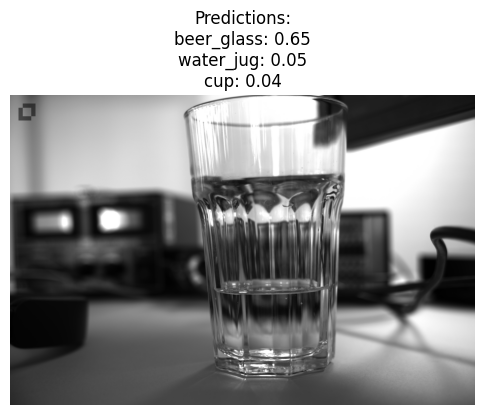

In [13]:

captured_image = capture_frame()
processed_image = preprocess_image(captured_image)
predictions = predict_image(processed_image)

# Display results
display_results(captured_image, predictions)
